### 画像リサイズ

In [14]:
import os
from PIL import Image
import glob

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "labeled/north/"
RESIZED_DIR = DUMP_DIR + "resized/north/"

def resize_image(image_file):
    RESIZE_VAL = 300 # resized pixel
    image = Image.open(image_file)
    image = image.convert("RGB")
    image = image.resize((RESIZE_VAL, RESIZE_VAL))
    return image # return image

def main():
    image_files = glob.glob(DATASET_DIR + "*.jpg")
    for image_file in image_files:
        image = resize_image(image_file)
        image.save(RESIZED_DIR + os.path.basename(image_file)) #save image

if __name__ == "__main__":
    main()


### アノテーションデータ読み込みとデータ作成
`fourth` ラベルのデータを以下の手法で水増しする
* グレースケール化
  - ただし，既にグレースケールのものは除く
* ノイズ
* 輝度を下げる
* 輝度を上げる

In [15]:
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET
import numpy as np
import random, math

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
LABEL_LIST = ['not', 'fourth']

def make_npdataset(position: tuple, label_name: str, file_name: str):
    """from annotate data to numpy data"""
    RESIZE_val = 70, 40 # resize value(width, height)
    
    # get annotated rect's image
    image = Image.open(file_name).convert("RGB")
    image_cropped = image.crop(position)
    image_cropped = image_cropped.resize(RESIZE_val)
    
    # get label index
    label = LABEL_LIST.index(label_name)
    
    return np.asarray(image_cropped), label

def make_npdatasets(annotate_files: list):
    """create annotated image's dataset"""
    datasets = []
    OBJECT_QUERY = './/object'
    for annotate_file in annotate_files:
        tree = ET.parse(annotate_file)
        root = tree.getroot()

        image_filename = root.find('path').text # get image's filename
        for xml_elem in root.findall(OBJECT_QUERY):
            # get annotated rect's position
            position = int(xml_elem.find('bndbox/xmin').text), int(xml_elem.find('bndbox/ymin').text), int(xml_elem.find('bndbox/xmax').text), int(xml_elem.find('bndbox/ymax').text)
            label_name = xml_elem.find('name').text
            datasets.append(make_npdataset(position, label_name, image_filename))
        
    return datasets

def main():
    annotate_files = glob.glob(DATASET_DIR + "*.xml")
    datasets = make_npdatasets(annotate_files)
    random.shuffle(datasets) # shuffle datasets

    # split datasets
    train_size = math.floor(len(datasets) * 0.6)
    val_size = math.floor(len(datasets) * 0.2)
    X_train, y_train = np.array([data[0] for data in datasets[0:train_size]]), np.array([data[1] for data in datasets[0:train_size]])
    X_val, y_val = np.array([data[0] for data in datasets[train_size:train_size + val_size]]), np.array([data[1] for data in datasets[train_size:train_size + val_size]])
    X_test, y_test = np.array([data[0] for data in datasets[train_size + val_size:]]), np.array([data[1] for data in datasets[train_size + val_size:]])
    
    # save dataset array
    xy = (X_train, X_val, X_test, y_train, y_val, y_test)
    np.save(DUMP_DIR + "floor_datasets.npy", xy)

if __name__ == "__main__":
    main()

### CNNよる分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 38, 68, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 34, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20672)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               10584576  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 10,585,985
Trainable params: 10,585,985
Non-trainable params: 0
_________________________________________________________________
Train on 871 samples, validate on 290 samples
Epoch 1/10
871/871 [==============================] - 16s 18ms/step - loss: 0.5153 -

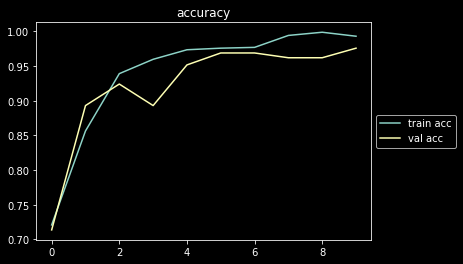

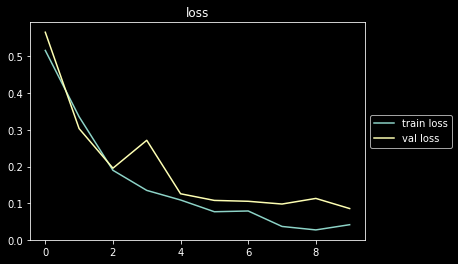

290/290 [==============================] - 0s 1ms/step
test loss: 0.052772610384071696
test acc: 0.9862068965517241


In [16]:
from keras import layers, models, backend
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
LABEL_LIST = ['not', 'fourth']
RESIZE_val = 40, 70 # resize value(height, width)

%matplotlib inline

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=tuple(list(RESIZE_val) + [3]))) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(512, activation="relu")) # dense layer
    model.add(layers.Dense(1, activation="sigmoid")) # logistic regression (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_val = X_val.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="val acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='val loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def evaluate_data(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_test  = X_test.astype("float")  / 255
    eval_stack = model.evaluate(x=X_test, y=y_test)
    return eval_stack

def main():
    datasets_path = DUMP_DIR + "/floor_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # evaluate by testsets
    eval_stack = evaluate_data(model, datasets_path)
    print("test loss: " + str(eval_stack[0]))
    print("test acc: " + str(eval_stack[1]))

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/floor_model_logistic.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/floor_params_logistic.hdf5")

if __name__ == "__main__":
    main()


### Sliding Windowによる認識
falseの例を抽出してアノテーションデータとして出力する．

In [17]:
import os
from keras import models
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import random
import math

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"
DATASET_DIR = DUMP_DIR + "annotated/north/"
RESIZED_DIR = DUMP_DIR + "resized/north/"
LABEL_LIST = ['not', 'fourth']
WINDOW_val = 70, 40 # resize value(width, height)

# load model
global model
with open(DUMP_DIR + "floor_model_logistic.json", 'r') as f:
    model = models.model_from_json(f.read())
    model.load_weights(DUMP_DIR + "floor_params_logistic.hdf5")
    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    
def make_npdataset(position: tuple, label_name: str, file_name: str):
    """from annotate data to numpy data"""
    RESIZE_val = 70, 40 # resize value(width, height)
    
    # get annotated rect's image
    image = Image.open(file_name).convert("RGB")
    image_cropped = image.crop(position)
    image_cropped = image_cropped.resize(RESIZE_val)
    
    # get label index
    label = LABEL_LIST.index(label_name)
    
    return np.asarray(image_cropped), label

def predict_floor(image_nd: np.ndarray):
    """predict class"""
    return model.predict(image_nd)

def predict_window(image_path: str):
    """predict floor's window"""
    image = Image.open(image_path)
    candidate_positions = []
    window_times = 5
    # sliding at x
    for x_start in range(0, image.width - WINDOW_val[0], WINDOW_val[0] // window_times):
        # sliding at y
        for y_start in range(0, image.height - WINDOW_val[1], WINDOW_val[1] // window_times):
            image_cropped = image.crop((x_start, y_start, x_start + WINDOW_val[0], y_start + WINDOW_val[1]))
            result = predict_floor(np.expand_dims(np.asarray(image_cropped), axis=0))
            
            # show image
            if result[0][0] >= 1:
                candidate_positions.append((x_start, y_start, x_start + WINDOW_val[0], y_start + WINDOW_val[1]))
                
    return candidate_positions

def show_candidate_rect(image_path: str, positions: list):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    false_positions = make_false_annotate(image_path, positions)
    if bool(false_positions): # image has annotated data
        for pos in positions:
            draw.rectangle(pos, outline="blue") # draw window's rect
        
        for pos in false_positions:
            draw.rectangle(pos, outline="red") # overwrite window's rect
    
    else:
        for pos in positions:
            draw.rectangle(pos, outline="red") # draw window's rect
        
    image.show() # show image
    
def make_false_annotate(image_path: str, positions: list):
    DIFF_PERCENT = 0.1 # differece percentage
    # annotate file path
    annotate_path = os.path.join(DATASET_DIR, os.path.basename(image_path).split(".")[0] + ".xml")
    if os.path.exists(annotate_path) == False:
        return # exit
    tree = ET.parse(annotate_path)
    root = tree.getroot()
    
    # get true annotate position
    child = root.find(".//object/[name='fourth']/bndbox")
    if child == None:
        print(image_path)
    true_pos = int(child.find("xmin").text), int(child.find("ymin").text)
    
    # calc false positions
    false_positions = []
    for pos in positions:
        if abs(true_pos[0] - pos[0]) / true_pos[0] <= DIFF_PERCENT and abs(true_pos[1] - pos[1]) / true_pos[1] <= DIFF_PERCENT:
            continue # true position
        else:
            # false position
            false_positions.append(pos)
    
    return false_positions

def main():
    false_datasets = []
    for i, image_path in enumerate(tqdm(glob.glob(RESIZED_DIR + "*.jpg"))):
    #for i, image_path in enumerate(glob.glob(RESIZED_DIR + "*.jpg")):
        false_annotate = []
        positions = predict_window(image_path)
        
        make_false_annotate(image_path, positions)
        # sampling
        if i >= 0 and i < 30:
            show_candidate_rect(image_path, positions)
            
        false_annotate = make_false_annotate(image_path, positions)
        if not(false_annotate == None):
            for false_pos in false_annotate:
                false_datasets.append(make_npdataset(false_pos, LABEL_LIST[0], image_path))

    # shuffle datasets
    random.shuffle(false_datasets)
    
    # split datasets
    train_size = math.floor(len(false_datasets) * 0.6)
    val_size = math.floor(len(false_datasets) * 0.2)
    X_train, y_train = np.array([data[0] for data in false_datasets[0:train_size]]), np.array([data[1] for data in false_datasets[0:train_size]])
    X_val, y_val = np.array([data[0] for data in false_datasets[train_size:train_size + val_size]]), np.array([data[1] for data in false_datasets[train_size:train_size + val_size]])
    X_test, y_test = np.array([data[0] for data in false_datasets[train_size + val_size:]]), np.array([data[1] for data in false_datasets[train_size + val_size:]])
    
    # save dataset array
    xy = (X_train, X_val, X_test, y_train, y_val, y_test)
    #np.save(DUMP_DIR + "floor_false_datasets.npy", xy)

if __name__ == "__main__":
    main()

 25%|██▌       | 146/573 [05:22<17:06,  2.41s/it]

KeyboardInterrupt: 

### データセットの結合
キャッシュしたfalseデータセットとアノテーションデータセットの結合

In [23]:
import shutil
import numpy as np
import math
import random

# const
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump/"

def main():
    # duplicate old datasets
    #shutil.copyfile(DUMP_DIR + "floor_datasets.npy", DUMP_DIR + "floor_datasets.npy.old")
    
    # concat datasets
    datasets = np.load(DUMP_DIR + "floor_datasets.npy")
    datasets_false = np.load(DUMP_DIR + "floor_false_datasets.npy")
    
    # use in len(false) * false_ration
    false_ratio = 0.07

    train_false_size = math.floor(datasets_false[0].shape[0] * false_ratio)
    val_false_size = math.floor(datasets_false[1].shape[0] * false_ratio)
    test_false_size = math.floor(datasets_false[2].shape[0] * false_ratio)

    train = list(zip(np.concatenate([datasets[0], datasets_false[0][0:train_false_size]], axis=0).tolist(), np.concatenate([datasets[3], datasets_false[3][0:train_false_size]], axis=0).tolist()))
    val = list(zip(np.concatenate([datasets[1], datasets_false[1][0:val_false_size]], axis=0), np.concatenate([datasets[4], datasets_false[4][0:val_false_size]], axis=0)))
    test = list(zip(np.concatenate([datasets[2], datasets_false[2][0:test_false_size]], axis=0), np.concatenate([datasets[5], datasets_false[5][0:test_false_size]], axis=0)))
    
    print(datasets[3].tolist().count(0))
    print(datasets[3].tolist().count(1))
    
    print(np.concatenate([datasets[3], datasets_false[3][0:train_false_size]], axis=0).tolist().count(0))
    print(np.concatenate([datasets[3], datasets_false[3][0:train_false_size]], axis=0).tolist().count(1))
    
    # shuffle datasets
    random.shuffle(train)
    random.shuffle(val)
    random.shuffle(test)
    
    X_train, y_train = np.array([data[0] for data in train]), np.array([data[1] for data in train])
    X_val, y_val = np.array([data[0] for data in val]), np.array([data[1] for data in val])
    X_test, y_test = np.array([data[0] for data in test]), np.array([data[1] for data in test])

    # save dataset array
    xy = (X_train, X_val, X_test, y_train, y_val, y_test)
    #np.save(DUMP_DIR + "floor_datasets.npy", xy)
    
if __name__ == "__main__":
    main()

533
338
990
338
